<a href="https://colab.research.google.com/github/OmerNachshon/Titanic---Machine-Learning-from-Disaster-1/blob/main/titanic_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/om3rnach/account , omer nachshon 209006535

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

# TL;DR
Goal: predict the number of survivors on the Titanic
Approach:
* Replace all non numeric values to numeric values
* Fill/Drop missing values 
* Drop irrelevent features
* Seperate dataset into dependant and independant features 
* Split using train_test_split module to train our model
* Use LogisticRegression, SGDClassifier ,MLPClassifier
* Choose best model

# Data Overview + Import Dataset

In [ ]:
train = pd.read_csv('./sample_data/train.csv')
test = pd.read_csv('./sample_data/test.csv')
id_col=test['PassengerId']





In [ ]:
train.head()  # look at our train data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# First Conclusions From Overview

2/891 embarked are missing  , not critical

687/891 cabin are missing , needs to be dropped

177/891 age are missing  , ?

# EDA

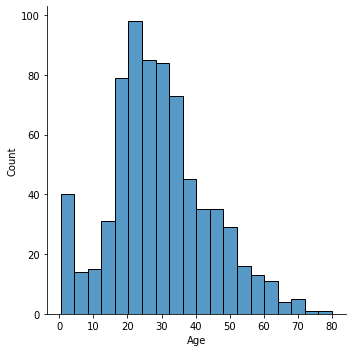

In [ ]:
sns.displot(x='Age', data=train)
plt.show()

In [ ]:
train['Age'].median()

28.0

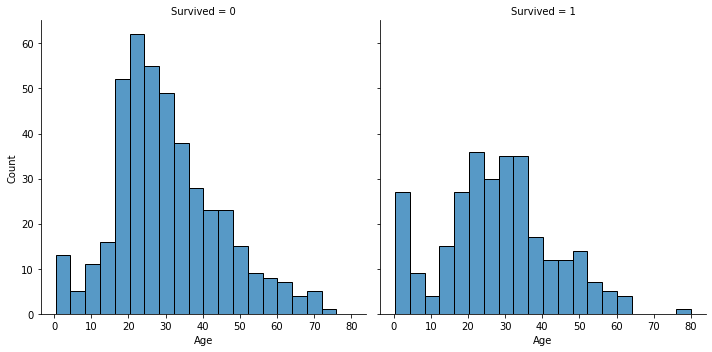

In [ ]:
sns.displot(x='Age', data=train, col='Survived')
plt.show()

In [ ]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

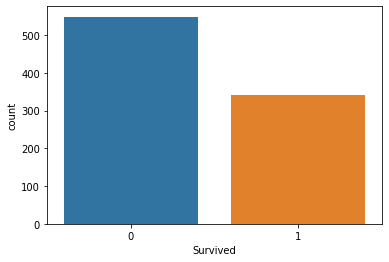

In [ ]:
sns.countplot(data=train,x='Survived')

# Drop Irrelevant Columns (PassengerId,Name)

In [ ]:
train.drop('PassengerId', axis=1 , inplace=True)
train.drop('Name', axis=1 , inplace=True)
train.drop('Ticket',axis=1,inplace=True)
test.drop('PassengerId', axis=1 , inplace=True)
test.drop('Name', axis=1 , inplace=True)
test.drop('Ticket',axis=1,inplace=True)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [ ]:
train.corr()['Survived'].sort_values()

Pclass     -0.338481
Age        -0.077221
SibSp      -0.035322
Parch       0.081629
Fare        0.257307
Survived    1.000000
Name: Survived, dtype: float64

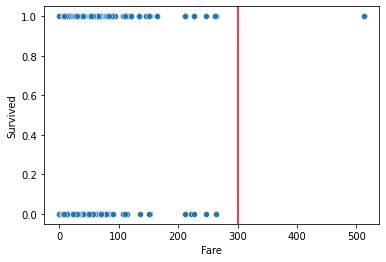

In [ ]:
sns.scatterplot(data=train, x='Fare', y='Survived')
plt.axvline(x=300 , color='r')

we can see that only a minority paid over 300 fare

In [ ]:
train[train['Fare']>300]['Fare'].count()

3

In [ ]:
train[(train['Fare']>300)][['Fare']]

,Fare
258,512.3292
679,512.3292
737,512.3292




```
# This is formatted as code
```

# Drop Exceptions

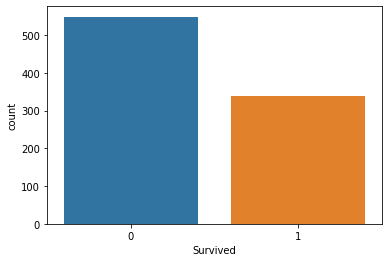

In [ ]:
train=train.drop(train[(train['Fare']>300)].index)
sns.countplot(data=train[train['Fare']<300],x='Survived')


In [ ]:
train[train['Fare']>300]['Fare'].count()

0

Exceptions were dropped 

# Check Missing Data

In [ ]:
((train.isnull().sum())/len(train))*100


Survived     0.000000
Pclass       0.000000
Sex          0.000000
Age         19.932432
SibSp        0.000000
Parch        0.000000
Fare         0.000000
Cabin       77.252252
Embarked     0.225225
dtype: float64

based on the missing percentage , we will :
1) fill embarked with most popular value (if there is)

2) fill age with the median (we know already that most passengers are males in their 20-35)

3)  drop cabin because almost 80% are missing , so the value is useless for our model

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

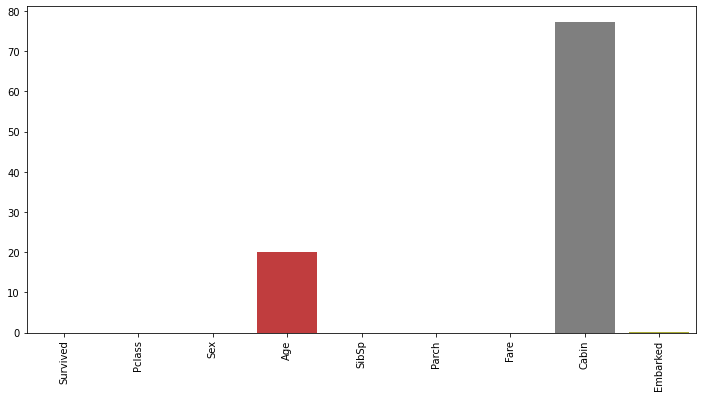

In [ ]:
missing_percent=((train.isnull().sum())/len(train))*100
plt.figure(figsize=(12,6))
sns.barplot(x=missing_percent.index , y=missing_percent)
plt.xticks(rotation=90)

# Clean Data

1)

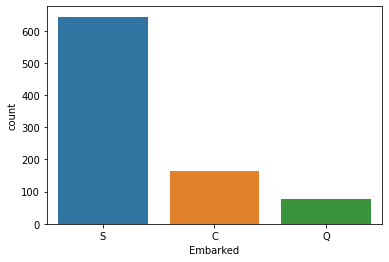

In [ ]:
sns.countplot(data=train,x=train['Embarked'])

In [ ]:
train['Embarked'].value_counts()

S    644
C    165
Q     77
Name: Embarked, dtype: int64

we can see that s is the most popular embarked value , lets fill the null rows with s.

In [ ]:
train['Embarked'].fillna("S", inplace=True) 
test['Embarked'].fillna("S", inplace=True) 
train['Embarked'].value_counts()

S    646
C    165
Q     77
Name: Embarked, dtype: int64

2)

In [ ]:
train["Age"].fillna(train["Age"].median(), inplace = True)
test["Age"].fillna(train["Age"].median(), inplace = True)
test["Fare"].fillna(test["Fare"].median(), inplace = True)

3)

In [ ]:
train.drop('Cabin',axis=1,inplace=True)
test.drop('Cabin',axis=1,inplace=True)

let's see again the status of missing values

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

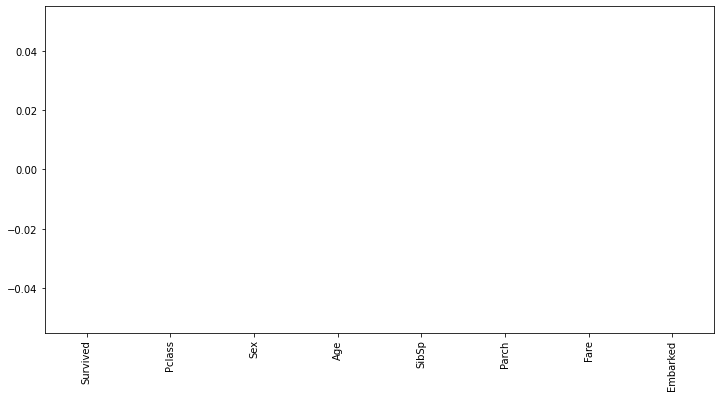

In [ ]:
missing_percent=((train.isnull().sum())/len(train))*100
plt.figure(figsize=(12,6))
sns.barplot(x=missing_percent.index , y=missing_percent)
plt.xticks(rotation=90)

Great! , now we can work on our features , create hyperparameters before we get to training!

In [ ]:
# converting SibSp and Parch to single feature of Family
def has_family(data):
    if  (data['SibSp'] + data['Parch'])  > 0:
        return 1
    else:
        return 0
    
def fare_per_pclass(data):
    return data['Fare']/data['Pclass']

def apply_hypers(data):
    data['Family'] = data.apply(has_family, axis = 1)
    data['FarePerPclass'] = data.apply(fare_per_pclass, axis = 1)

apply_hypers(train)
apply_hypers(test)
test['FarePerPclass'].fillna(test['FarePerPclass'].median(), inplace=True) 

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 890
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       888 non-null    int64  
 1   Pclass         888 non-null    int64  
 2   Sex            888 non-null    object 
 3   Age            888 non-null    float64
 4   SibSp          888 non-null    int64  
 5   Parch          888 non-null    int64  
 6   Fare           888 non-null    float64
 7   Embarked       888 non-null    object 
 8   Family         888 non-null    int64  
 9   FarePerPclass  888 non-null    float64
dtypes: float64(3), int64(5), object(2)
memory usage: 108.6+ KB


Prepare for training

In [ ]:
test['Sex']=test['Sex'].replace({'male':0,'female':1})
train['Sex']=train['Sex'].replace({'male':0,'female':1})
X=train.drop('Survived' , axis=1)
y=train['Survived']

In [ ]:
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,FarePerPclass
0,0,3,0,22.0,1,0,7.2500,S,1,2.416667
1,1,1,1,38.0,1,0,71.2833,C,1,71.283300
2,1,3,1,26.0,0,0,7.9250,S,0,2.641667
3,1,1,1,35.0,1,0,53.1000,S,1,53.100000
4,0,3,0,35.0,0,0,8.0500,S,0,2.683333
...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,S,0,6.500000
887,1,1,1,19.0,0,0,30.0000,S,0,30.000000
888,0,3,1,28.0,1,2,23.4500,S,1,7.816667
889,1,1,0,26.0,0,0,30.0000,C,0,30.000000


In [ ]:
le = preprocessing.LabelEncoder()
train['Embarked'] = le.fit_transform(train['Embarked'])
test['Embarked'] = le.fit_transform(test['Embarked'])
train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,FarePerPclass
0,0,3,0,22.0,1,0,7.2500,2,1,2.416667
1,1,1,1,38.0,1,0,71.2833,0,1,71.283300
2,1,3,1,26.0,0,0,7.9250,2,0,2.641667
3,1,1,1,35.0,1,0,53.1000,2,1,53.100000
4,0,3,0,35.0,0,0,8.0500,2,0,2.683333
5,0,3,0,28.0,0,0,8.4583,1,0,2.819433
6,0,1,0,54.0,0,0,51.8625,2,0,51.862500
7,0,3,0,2.0,3,1,21.0750,2,1,7.025000
8,1,3,1,27.0,0,2,11.1333,2,1,3.711100
9,1,2,1,14.0,1,0,30.0708,0,1,15.035400


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 890
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       888 non-null    int64  
 1   Pclass         888 non-null    int64  
 2   Sex            888 non-null    int64  
 3   Age            888 non-null    float64
 4   SibSp          888 non-null    int64  
 5   Parch          888 non-null    int64  
 6   Fare           888 non-null    float64
 7   Embarked       888 non-null    int64  
 8   Family         888 non-null    int64  
 9   FarePerPclass  888 non-null    float64
dtypes: float64(3), int64(7)
memory usage: 108.6 KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         418 non-null    int64  
 1   Sex            418 non-null    int64  
 2   Age            418 non-null    float64
 3   SibSp          418 non-null    int64  
 4   Parch          418 non-null    int64  
 5   Fare           418 non-null    float64
 6   Embarked       418 non-null    int64  
 7   Family         418 non-null    int64  
 8   FarePerPclass  418 non-null    float64
dtypes: float64(3), int64(6)
memory usage: 29.5 KB


In [ ]:
X_train , X_test ,y_train, y_test=train_test_split(X, y , test_size=0.1, random_state=42)

In [ ]:
X_train['Embarked'] = le.fit_transform(X_train['Embarked'])
X_test['Embarked'] = le.fit_transform(X_test['Embarked'])

In [ ]:
log_model=LogisticRegression(random_state=42, solver="liblinear")
log_model.fit(X_train,y_train)
log_predict=log_model.predict(X_test)

In [ ]:
sgd = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000,random_state=42))
sgd.fit(X_train, y_train)
sgd_predict = sgd.predict(X_test)

mlp = make_pipeline(StandardScaler(),MLPClassifier(max_iter=300))
mlp.fit(X_train, y_train)
mlp_predict = mlp.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
accuracy = accuracy_score(y_test, log_predict)
print('LR accuracy - ', accuracy)

accuracy = accuracy_score(y_test, sgd_predict)
print('SGD accuracy - ', accuracy)

accuracy = accuracy_score(y_test, mlp_predict)
print('MLP accuracy - ', accuracy)

LR accuracy -  0.8426966292134831
SGD accuracy -  0.8202247191011236
MLP accuracy -  0.8539325842696629


lets go with mlp because of highest score

In [ ]:
final_pred=mlp.predict(test)

In [ ]:
len(final_pred)

418

In [ ]:
final_submission = pd.DataFrame({"PassengerId": id_col.values, "Survived": final_pred})
final_submission.to_csv('final_submission.csv', index=False)

In [ ]:
final_sub = pd.read_csv('./final_submission.csv')
len(final_sub)

418